In [2]:
#import statements
import matplotlib.patches as patches
import networkx as nx
import torch.distributions
import torch
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame
import gym
import random
import numpy as np
#import helpers
import imageio
import matplotlib.pyplot as plt
import typing
import math
import pickle

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
#from src.policies_impala import ImpalaCNN

from gym3 import ToBaselinesVecEnv
import seaborn as sns
import random

%load_ext autoreload
%autoreload 2

In [3]:
# Dictionary of ordered layer names
ordered_layer_names = {
 1: 'conv_seqs.0',
 2: 'conv_seqs.0.conv',
 3: 'conv_seqs.0.max_pool2d',
 4: 'conv_seqs.0.res_block0',
 5: 'conv_seqs.0.res_block0.conv0',
 6: 'conv_seqs.0.res_block0.conv1',
 7: 'conv_seqs.0.res_block1',
 8: 'conv_seqs.0.res_block1.conv0',
 9: 'conv_seqs.0.res_block1.conv1',
 10: 'conv_seqs.1',
 11: 'conv_seqs.1.conv',
 12: 'conv_seqs.1.max_pool2d',
 13: 'conv_seqs.1.res_block0',
 14: 'conv_seqs.1.res_block0.conv0',
 15: 'conv_seqs.1.res_block0.conv1',
 16: 'conv_seqs.1.res_block1',
 17: 'conv_seqs.1.res_block1.conv0',
 18: 'conv_seqs.1.res_block1.conv1',
 19: 'conv_seqs.2',
 20: 'conv_seqs.2.conv',
 21: 'conv_seqs.2.max_pool2d',
 22: 'conv_seqs.2.res_block0',
 23: 'conv_seqs.2.res_block0.conv0',
 24: 'conv_seqs.2.res_block0.conv1',
 25: 'conv_seqs.2.res_block1',
 26: 'conv_seqs.2.res_block1.conv0',
 27: 'conv_seqs.2.res_block1.conv1',
 28: 'hidden_fc',
 29: 'logits_fc',
 30: 'value_fc'
}

# Extracting all the names into a list
layer_names = list(ordered_layer_names.values())
channels = {}
for layer_name in layer_names:
    if layer_name.startswith("conv_seqs.0"):
        channels[layer_name] = 16
    elif layer_name.startswith("conv"):
        channels[layer_name] = 32
    else:
        channels[layer_name] = 1

print(layer_names)


['conv_seqs.0', 'conv_seqs.0.conv', 'conv_seqs.0.max_pool2d', 'conv_seqs.0.res_block0', 'conv_seqs.0.res_block0.conv0', 'conv_seqs.0.res_block0.conv1', 'conv_seqs.0.res_block1', 'conv_seqs.0.res_block1.conv0', 'conv_seqs.0.res_block1.conv1', 'conv_seqs.1', 'conv_seqs.1.conv', 'conv_seqs.1.max_pool2d', 'conv_seqs.1.res_block0', 'conv_seqs.1.res_block0.conv0', 'conv_seqs.1.res_block0.conv1', 'conv_seqs.1.res_block1', 'conv_seqs.1.res_block1.conv0', 'conv_seqs.1.res_block1.conv1', 'conv_seqs.2', 'conv_seqs.2.conv', 'conv_seqs.2.max_pool2d', 'conv_seqs.2.res_block0', 'conv_seqs.2.res_block0.conv0', 'conv_seqs.2.res_block0.conv1', 'conv_seqs.2.res_block1', 'conv_seqs.2.res_block1.conv0', 'conv_seqs.2.res_block1.conv1', 'hidden_fc', 'logits_fc', 'value_fc']


In [4]:

def wrap_venv(venv) -> ToBaselinesVecEnv:
    "Wrap a vectorized env, making it compatible with the gym apis, transposing, scaling, etc."

    venv = ToBaselinesVecEnv(venv)  
    venv = VecExtractDictObs(venv, "rgb")

    venv = TransposeFrame(venv)
    venv = ScaledFloatFrame(venv)
    return venv  

def create_venv(
    num: int, start_level: int, num_levels: int, num_threads: int = 1, distribution_mode: str = "easy"
):
    """
    Create a wrapped venv. See https://github.com/openai/procgen#environment-options for params

    num=1 - The number of parallel environments to create in the vectorized env.

    num_levels=0 - The number of unique levels that can be generated. Set to 0 to use unlimited levels.

    start_level=0 - The lowest seed that will be used to generated levels. 'start_level' and 'num_levels' fully specify the set of possible levels.
    """
    venv = ProcgenGym3Env(
        num=num,
        env_name="heist",
        num_levels=num_levels,
        start_level=start_level,
        distribution_mode=distribution_mode,
        num_threads=num_threads,
        render_mode="rgb_array",
    )
    venv = wrap_venv(venv)
    return venv

In [5]:
import torch
import heist
def make_batch_input(num_inputs):
 # Number of inputs in the batch
    corrupt_inputs = []
    inputs = []
    
    for _ in range(num_inputs):
        start_level = random.randint(1, 10000)
        venv = create_venv(num=1, num_levels=1, start_level=start_level)
        state = heist.state_from_venv(venv, 0)
        corrupt_input = venv.reset()
        corrupt_input = helpers.observation_to_rgb(corrupt_input)
        corrupt_input_tensor = torch.tensor(corrupt_input, dtype=torch.float32)  # Convert each to tensor
        corrupt_input_tensor = torch.squeeze(corrupt_input_tensor, 0)  # Remove the singleton dimension
        corrupt_inputs.append(corrupt_input_tensor)


        state_values = state.state_vals

        for ents in state_values["ents"]:
            if ents["image_type"].val== 9:
                gem_x = ents["x"].val 
                gem_y = ents["y"].val 
        
        state.remove_gem()
        
        state_bytes = state.state_bytes

        venv.env.callmethod("set_state", [state_bytes])
        input = venv.reset()
        input = helpers.observation_to_rgb(input)
        input_tensor = torch.tensor(input, dtype=torch.float32)  # Convert each to tensor
        input_tensor = torch.squeeze(input_tensor, 0)  # Remove the singleton dimension
        inputs.append(input_tensor)

    # Stack inputs into a single tensor to maintain correct shape
    corrupt_inputs = torch.stack(corrupt_inputs).permute(0,2,3,1)  # This will now be [5, 3, 64, 64]
    inputs =torch.stack(inputs).permute(0,2,3,1)  

    return inputs, corrupt_inputs
    

building procgen...

/Users/bensturgeon/mambaforge/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
/Users/bensturgeon/mambaforge/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


done


In [6]:
def create_classified_dataset(num_samples_per_category=5, num_levels=0):
    dataset = {
        "gem": [],
        "gem_removed": [],
        "blue_key": [],
        "blue_key_removed": [],
        "green_key": [],
        "green_key_removed": [],
        "red_key": [],
        "red_key_removed": [],
        "blue_lock": [],
        "blue_lock_removed": [],
        "green_lock": [],
        "green_lock_removed": [],
        "red_lock": [],
        "red_lock_removed": []
    }

    key_indices = {"blue": 0, "green": 1, "red": 2}

    

    while any(len(samples) < num_samples_per_category for samples in dataset.values()):
        venv = create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
        state = heist.state_from_venv(venv, 0)
        key_colors = state.get_key_colors()

        if not key_colors:
            if len(dataset["gem"]) < num_samples_per_category:
                state_bytes = state.state_bytes
                if state_bytes is not None:
                    venv.env.callmethod("set_state", [state_bytes])
                    obs = venv.reset()
                    dataset["gem"].append(obs[0].transpose(1,2,0))
                    state = heist.state_from_venv(venv, 0)
                    state_values = state.state_vals

                    for ents in state_values["ents"]:
                        if ents["image_type"].val== 9:
                            gem_x = ents["x"].val 
                            gem_y = ents["y"].val 
                    
                    state.remove_gem()
                    
                    state_bytes = state.state_bytes
            
                    venv.env.callmethod("set_state", [state_bytes])
                    clean_obs = venv.reset()
                    dataset["gem_removed"].append(clean_obs[0].transpose(1,2,0))
                    
        else:
            if "red" in key_colors:
                if len(dataset["red_key"]) < num_samples_per_category:
                    state.delete_keys_and_locks(3)
                    state_bytes = state.state_bytes
                    if state_bytes is not None:
                        venv.env.callmethod("set_state", [state_bytes])
                        obs = venv.reset()
                        dataset["red_key"].append(obs[0].transpose(1,2,0))
                    state = heist.state_from_venv(venv, 0)
                    state_values = state.state_vals
                    #remove red key
                    state.delete_specific_keys([2])
                    
                    state_bytes = state.state_bytes
            
                    venv.env.callmethod("set_state", [state_bytes])
                    clean_obs = venv.reset()
                    dataset["red_key_removed"].append(clean_obs[0].transpose(1,2,0))


                
                        
                if len(dataset["red_lock"]) < num_samples_per_category:
                    state.delete_keys()
                    state_bytes = state.state_bytes
                    if state_bytes is not None:
                        venv.env.callmethod("set_state", [state_bytes])
                        obs = venv.reset()
                        dataset["red_lock"].append(obs[0].transpose(1,2,0))
                    #create a dataset where the red locks are removed
                    state = heist.state_from_venv(venv, 0)
                    state_values = state.state_vals
                    #remove red key
                    state.delete_specific_locks([2])                   
                    state_bytes = state.state_bytes
            
                    venv.env.callmethod("set_state", [state_bytes])
                    clean_obs = venv.reset()
                    dataset["red_lock_removed"].append(clean_obs[0].transpose(1,2,0))

            
            elif "green" in key_colors:
                if len(dataset["green_key"]) < num_samples_per_category:
                    state.delete_keys_and_locks(2)
                    state_bytes = state.state_bytes
                    if state_bytes is not None:
                        venv.env.callmethod("set_state", [state_bytes])
                        obs = venv.reset()
                        dataset["green_key"].append(obs[0].transpose(1,2,0))
                    #create a dataset where the green key are removed
                    state = heist.state_from_venv(venv, 0)
                    state_values = state.state_vals
                    # key_indices = {"blue": 0, "green": 1, "red": 2}
                    state.delete_specific_keys([1])                   
                    state_bytes = state.state_bytes         
                    venv.env.callmethod("set_state", [state_bytes])
                    clean_obs = venv.reset()
                    dataset["green_key_removed"].append(clean_obs[0].transpose(1,2,0))
                    
                if len(dataset["green_lock"]) < num_samples_per_category:
                    state.delete_keys()
                    state_bytes = state.state_bytes
                    if state_bytes is not None:
                        venv.env.callmethod("set_state", [state_bytes])
                        obs = venv.reset()
                        dataset["green_lock"].append(obs[0].transpose(1,2,0))

                    #create a dataset where the green lock are removed
                    state = heist.state_from_venv(venv, 0)
                    state_values = state.state_vals
                    # key_indices = {"blue": 0, "green": 1, "red": 2}
                    state.delete_specific_locks([1])                   
                    state_bytes = state.state_bytes         
                    venv.env.callmethod("set_state", [state_bytes])
                    clean_obs = venv.reset()
                    dataset["green_lock_removed"].append(clean_obs[0].transpose(1,2,0))

            elif "blue" in key_colors:
                if len(dataset["blue_key"]) < num_samples_per_category:
                    state_bytes = state.state_bytes
                    if state_bytes is not None:
                        venv.env.callmethod("set_state", [state_bytes])
                        obs = venv.reset()
                        dataset["blue_key"].append(obs[0].transpose(1,2,0))

                    #create a dataset where the blue key is removed
                    state = heist.state_from_venv(venv, 0)
                    state_values = state.state_vals
                    # key_indices = {"blue": 0, "green": 1, "red": 2}
                    state.delete_specific_keys([0])                   
                    state_bytes = state.state_bytes         
                    venv.env.callmethod("set_state", [state_bytes])
                    clean_obs = venv.reset()
                    dataset["blue_key_removed"].append(clean_obs[0].transpose(1,2,0))

                if len(dataset["blue_lock"]) < num_samples_per_category:
                    state.delete_keys()
                    state_bytes = state.state_bytes
                    if state_bytes is not None:
                        venv.env.callmethod("set_state", [state_bytes])
                        obs = venv.reset()
                        dataset["blue_lock"].append(obs[0].transpose(1,2,0))

                    #create a dataset where the blue lock is removed
                    state = heist.state_from_venv(venv, 0)
                    state_values = state.state_vals
                    # key_indices = {"blue": 0, "green": 1, "red": 2}
                    state.delete_specific_locks([0])                   
                    state_bytes = state.state_bytes         
                    venv.env.callmethod("set_state", [state_bytes])
                    clean_obs = venv.reset()
                    dataset["blue_lock_removed"].append(clean_obs[0].transpose(1,2,0))

        venv.close()

    return dataset

In [7]:
from collections import defaultdict
from typing import List, Dict, Tuple
 
class Node:
    def __init__(self, name: str):
        self.name = name
        self.visited = False
        self.children = []
        self.parents = []


    def add_child(self, child_node):
        self.children.append(child_node)
        child_node.parents.append(self)

    def remove_child(self, child_node):
        if child_node in self.children:
            self.children.remove(child_node)
        if self in child_node.parents:
            child_node.parents.remove(self)

class Graph:
    def __init__(self):
        self.nodes = {}  # Maps node names to Node objects

    def add_node(self, name: str):
        if name not in self.nodes:
            self.nodes[name] = Node(name)
        return self.nodes[name]

    def add_edge(self, parent_name: str, child_name: str):
        parent_node = self.add_node(parent_name)
        child_node = self.add_node(child_name)
        parent_node.add_child(child_node)
    def add_edge_with_channels(self, parent_name: str, child_name: str):
        parent_channels = channels[parent_name]
        child_channels = channels[child_name]
        for parent_channel in range(parent_channels):
            for child_channel in range(child_channels):
                self.add_edge(parent_name+".channel"+str(parent_channel), child_name+".channel" + str(child_channel))

    def remove_edge(self, parent_name: str, child_name: str):
        try:
            parent_node = self.nodes[parent_name]
            child_node = self.nodes[child_name]
            parent_node.remove_child(child_node)
        except KeyError as e:
            print(f"Couldn't index in - are you sure this edge exists between {parent_name} and {child_name}?")
            raise e

    def display(self):
        for name, node in self.nodes.items():
            children_names = [child.name for child in node.children]
            parent_names = [parent.name for parent in node.parents]
            print(f'Node {name} has children: {children_names} and parents: {parent_names}')
    def save_to_file(self, file_name: str):
        with open(file_name, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_from_file(file_name: str):
        with open(file_name, 'rb') as f:
            return pickle.load(f)
def build_graph():
    graph = Graph()

    # Define the sequence names and their respective channels
    sequences = ['conv_seqs.0', 'conv_seqs.1', 'conv_seqs.2']
    last_seq_output = 'input'

    # Connect each sequence and define internal module connections
    for i, seq in enumerate(sequences):
        #add the skip connections
        graph.add_edge_with_channels(f'{seq}.max_pool2d', f'{seq}.res_block0')
        graph.add_edge_with_channels(f'{seq}.res_block0', f'{seq}.res_block1')  

        # Connect within ConvSequence
        graph.add_edge_with_channels(f'{seq}.conv', f'{seq}.max_pool2d')
        graph.add_edge_with_channels(f'{seq}.max_pool2d', f'{seq}.res_block0.conv0')
        graph.add_edge_with_channels(f'{seq}.res_block0.conv0', f'{seq}.res_block0.conv1')
        graph.add_edge_with_channels(f'{seq}.res_block0.conv1', f'{seq}.res_block0')

        graph.add_edge_with_channels(f'{seq}.res_block0', f'{seq}.res_block1.conv0')
        graph.add_edge_with_channels(f'{seq}.res_block1.conv0', f'{seq}.res_block1.conv1')
        graph.add_edge_with_channels(f'{seq}.res_block1.conv1', f'{seq}.res_block1')    
        graph.add_edge_with_channels(f'{seq}.res_block1',f'{seq}')

    # Connect hidden_fc to logits_fc and value_fc
    graph.add_edge_with_channels(f'{sequences[0]}', f'{sequences[1]}.conv')
    graph.add_edge_with_channels(f'{sequences[1]}', f'{sequences[2]}.conv')

    for i in range(32):
        graph.add_edge(f'{sequences[2]}.channel{i}', 'hidden_fc')

    ''' For now let's only remove the channel connection
    graph.add_node('hidden_fc')
    graph.add_node('logits_fc')
    graph.add_node('value_fc')
    graph.add_edge('hidden_fc', 'logits_fc')
    graph.add_edge('hidden_fc', 'value_fc')
    '''
    return graph

In [8]:
import helpers
model_path = "../model_final.pt"
model = helpers.load_model(model_path=model_path)
graph = build_graph()
graph.display()

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = helpers.load_model(model_path=model_path)

Node conv_seqs.0.max_pool2d.channel0 has children: ['conv_seqs.0.res_block0.channel0', 'conv_seqs.0.res_block0.channel1', 'conv_seqs.0.res_block0.channel2', 'conv_seqs.0.res_block0.channel3', 'conv_seqs.0.res_block0.channel4', 'conv_seqs.0.res_block0.channel5', 'conv_seqs.0.res_block0.channel6', 'conv_seqs.0.res_block0.channel7', 'conv_seqs.0.res_block0.channel8', 'conv_seqs.0.res_block0.channel9', 'conv_seqs.0.res_block0.channel10', 'conv_seqs.0.res_block0.channel11', 'conv_seqs.0.res_block0.channel12', 'conv_seqs.0.res_block0.channel13', 'conv_seqs.0.res_block0.channel14', 'conv_seqs.0.res_block0.channel15', 'conv_seqs.0.res_block0.conv0.channel0', 'conv_seqs.0.res_block0.conv0.channel1', 'conv_seqs.0.res_block0.conv0.channel2', 'conv_seqs.0.res_block0.conv0.channel3', 'conv_seqs.0.res_block0.conv0.channel4', 'conv_seqs.0.res_block0.conv0.channel5', 'conv_seqs.0.res_block0.conv0.channel6', 'conv_seqs.0.res_block0.conv0.channel7', 'conv_seqs.0.res_block0.conv0.channel8', 'conv_seqs.0.

In [9]:
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

def format_layer_name(layer_name):
    return layer_name.replace('.', '_')

class ModelActivations:
    def __init__(self, model):
        self.activations = {}
        self.model = model
        self.hooks = []  # To keep track of hooks
        self.layer_paths = layer_names

    def clear_hooks(self):
        # Remove all previously registered hooks
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.activations = {}

    def get_activation(self, name):
        def hook(model, input, output):
            processed_output = []
            for item in output:
                if isinstance(item, torch.Tensor):
                    processed_output.append(item.detach())
                elif isinstance(item, torch.distributions.Categorical):
                    processed_output.append(item.logits.detach())
                else:
                    processed_output.append(item)
            self.activations[name] = tuple(processed_output)
        return hook

    def register_hook_by_path(self, path, name):
        elements = path.split('.')
        model = self.model
        for i, element in enumerate(elements):
            if '[' in element:
                base, index = element.replace(']', '').split('[')
                index = int(index)
                model = getattr(model, base)[index]
            else:
                model = getattr(model, element)
            if i == len(elements) - 1:
                hook = model.register_forward_hook(self.get_activation(name))
                self.hooks.append(hook)  # Keep track of the hook

    def run_with_cache(self, input):
        self.clear_hooks()  # Clear any existing hooks
        self.activations = {}  # Reset activations

        # Handle edge case: input is not a tensor
        if not isinstance(input, torch.Tensor):
            input = torch.tensor(input, dtype=torch.float32)


        # Check the shape of the input and reshape if necessary
        if input.shape == torch.Size([1, 3, 64, 64]):
            input = input.squeeze(0)  # Remove the batch dimension
        if input.shape == torch.Size([3, 64, 64]):
            input = input.permute(1, 2, 0)  # Switch dimensions to (64, 64, 3)


        # Handle edge case: empty layer_paths
        if not self.layer_paths:
            output = self.model(input)
            return output, self.activations

        # Register hooks for each layer path
        for path in self.layer_paths:
            try:
                self.register_hook_by_path(path, path.replace('.', '_'))
            except AttributeError:
                print(f"Warning: Layer '{path}' not found in the model. Skipping hook registration.")

        # Add batch dimension if missing
        if input.dim() == 3:
            input = input.unsqueeze(0)

        # Run the model with the registered hooks
        output = self.model(input)

        return output, self.activations
    

    def register_hook_by_path_variant(self, path, name, corrupt_cache, layer_name_channels, ablate):
        elements = path.split('.')
        model = self.model
        for i, element in enumerate(elements):
            if '[' in element:
                base, index = element.replace(']', '').split('[')
                index = int(index)
                if hasattr(model, base) and index < len(getattr(model, base)):
                    model = getattr(model, base)[index]
                else:
                    print(f"Attribute '{base}' or index '{index}' does not exist in the model.")
                    return
            else:
                if hasattr(model, element):
                    model = getattr(model, element)
                else:
                    print(f"Attribute '{element}' does not exist in the model.")
                    return
            if i == len(elements) - 1:
                hook = model.register_forward_hook(self.get_activation_variant(name, corrupt_cache, layer_name_channels, ablate))
                self.hooks.append(hook)
    def get_activation_variant(self, name, corrupt_cache={}, layer_name_channels={}, ablate=False):
        layer_name_channel_copy = {}
        for key, value in layer_name_channels.items():
            layer_name_channel_copy[key.replace('.','_')] = value
        def hook(model, input, output):
            self.activations[name] = output.detach()
            
            if name in layer_name_channel_copy:

                if ablate:
                    for channel in layer_name_channel_copy[name]:
                        output[:, channel, :, :] = 0
               
                elif name.replace('.','_') in corrupt_cache:
                    #print("name found in corrupt cache")
                    #corrupted_output = corrupt_cache[name][0].unsqueeze(0)
          
                    corrupted_output = torch.stack(list(corrupt_cache[name]),dim=0)

                    if corrupted_output.shape == output.shape:
                        #print("the dimension of the output", output.shape,corrupted_output.shape, name)
                        for channel in layer_name_channel_copy[name]:
                            print("patching in output")
                            output[:, channel, :, :] = corrupted_output[:, channel, :, :]
            return output
        return hook



    def patch_activations_variant(self, input, corrupt_cache={}, to_change_layer_name=[], ablate=False):
        '''
        layer_name_channels = {}
        layer_names =['conv_seqs.0', 'conv_seqs.0.conv', 'conv_seqs.0.max_pool2d', 
                      'conv_seqs.0.res_block0', 'conv_seqs.0.res_block0.conv0', 'conv_seqs.0.res_block0.conv1', 'conv_seqs.0.res_block1']

        
        #This is what corrupt cache looks like

        #(['conv_seqs_0_conv', 'conv_seqs_0_max_pool2d', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block0', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_0_res_block1', 'conv_seqs_0', 'conv_seqs_1_conv', 'conv_seqs_1_max_pool2d', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block0', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_1_res_block1', 'conv_seqs_1', 'conv_seqs_2_conv', 'conv_seqs_2_max_pool2d', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block0',
         # 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1', 'conv_seqs_2_res_block1', 
          #'conv_seqs_2', 'hidden_fc', 'logits_fc', 'value_fc'])
        for layer_name in layer_names:
            layer_name_channels[layer_name] = [0]
        '''
        layer_name_channels = {}
        for name in to_change_layer_name:
            if ".channel" in name:
                base_name, channel = name.rsplit(".channel", 1)
                channel = int(channel)
                if base_name in layer_name_channels:
                    layer_name_channels[base_name].append(channel)
                else:
                    layer_name_channels[base_name] = [channel]

                
        #print("layer_name_channels", layer_name_channels)
    

        # Register hooks with modified behavior
        for layer_path, channels in layer_name_channels.items():
            self.register_hook_by_path_variant(layer_path, layer_path.replace('.', '_'), corrupt_cache, layer_name_channels, ablate)
            

        # Handle the input tensor shape and type
        if not isinstance(input, torch.Tensor):
            input = torch.tensor(input, dtype=torch.float32)
        if input.shape == torch.Size([1, 3, 64, 64]):
            input = input.squeeze(0)
        if input.shape == torch.Size([3, 64, 64]):
            input = input.permute(1, 2, 0)
        if input.dim() == 3:
            input = input.unsqueeze(0)

        output = self.model(input)

        self.clear_hooks()

        return output, self.activations




In [10]:

model_activations = ModelActivations(model)
'''
inputs, corrupt_inputs = make_batch_input(5)
clean_output, clean_cache = model_activations.run_with_cache(inputs)
model_activations.clear_hooks()
corrupt_output, corrupt_cache = model_activations.run_with_cache(corrupt_inputs)
model_activations.clear_hooks()
'''
dataset = create_classified_dataset(num_samples_per_category=5, num_levels=1)
gem_samples = torch.tensor(dataset["gem"], dtype=torch.float)
print(gem_samples.shape)
gem_removed_samples = torch.tensor(dataset["gem_removed"], dtype=torch.float)
print(gem_removed_samples.shape)


clean_output, clean_cache = model_activations.run_with_cache(gem_removed_samples)
model_activations.clear_hooks()
corrupt_output, corrupt_cache = model_activations.run_with_cache(gem_samples)
model_activations.clear_hooks()
modified_output,_ = model_activations.patch_activations_variant(gem_removed_samples, corrupt_cache, to_change_layer_name=['conv_seqs.0.res_block0.channel0'], ablate=False)
print(clean_output[0].logits, corrupt_output[0].logits)
prob1 = torch.softmax(clean_output[0].logits, dim=1)
prob2 = torch.softmax(corrupt_output[0].logits, dim=1)
kl_div = torch.nn.functional.kl_div(torch.log(prob1), prob2, reduction='batchmean')
print("the kl divergence is", kl_div)


torch.Size([5, 64, 64, 3])
torch.Size([5, 64, 64, 3])
patching in output
tensor([[-1.3286, -1.3102, -2.1907, -2.2496, -5.8710, -5.1987, -3.0176, -6.3562,
         -5.0650, -2.5865, -4.4793, -2.6474, -5.2819, -3.9944, -6.3040],
        [-1.3275, -1.3116, -2.1936, -2.2495, -5.8700, -5.2000, -3.0188, -6.3572,
         -5.0674, -2.5834, -4.4768, -2.6448, -5.2803, -3.9930, -6.3018],
        [-1.3307, -1.3114, -2.1885, -2.2487, -5.8679, -5.1944, -3.0160, -6.3562,
         -5.0640, -2.5846, -4.4759, -2.6446, -5.2814, -3.9918, -6.3045],
        [-1.3287, -1.3104, -2.1917, -2.2492, -5.8701, -5.1983, -3.0176, -6.3565,
         -5.0643, -2.5856, -4.4778, -2.6465, -5.2811, -3.9932, -6.3033],
        [-1.3288, -1.3111, -2.1907, -2.2492, -5.8697, -5.1966, -3.0171, -6.3560,
         -5.0636, -2.5854, -4.4781, -2.6462, -5.2819, -3.9932, -6.3037]],
       grad_fn=<SubBackward0>) tensor([[-1.3287, -1.3101, -2.1903, -2.2499, -5.8709, -5.1984, -3.0177, -6.3563,
         -5.0650, -2.5866, -4.4794, -2.6475,

/var/folders/58/f16y6j7x0j5d0vv3pvq80c680000gn/T/ipykernel_19505/3052179519.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  gem_samples = torch.tensor(dataset["gem"], dtype=torch.float)


In [11]:
class RLPolicyExperiment():
    """
    A class to manage an experiment that adjusts and analyzes the components of an RL policy
    network dynamically during training, akin to the TLACDCExperiment for neural networks.
    """

    def __init__(self, model, threshold,graph,ablate, key_type):
        self.model = model
        self.model_activations = ModelActivations(model)
        #this should be input dataset
        self.threshold = threshold
        # Node definitions are based on the provided structure
        self.graph = graph
        self.removed_nodes = []
        self.removed_edges = []
        self.ablate = ablate
        self.mean_kl_divergences = 0
        self.key_type = key_type

        

    def reverse_topologically_sort_corr(self):
        #sorts the graph in reverse topological order
        order = []
        # Set all nodes as unvisited
        for node in self.graph.nodes.values():
            node.visited = False

        # Helper function to perform DFS
        def dfs(node):
            node.visited = True
            for child in node.children:
                if not child.visited:
                    dfs(child)
            # Prepend node to maintain reverse order
            order.insert(0, node.name)

        # Perform DFS from each unvisited node
        for node in self.graph.nodes.values():
            if not node.visited:
                dfs(node)
        return order

            
    def _on_step(self):
        dataset = create_classified_dataset(num_samples_per_category=100, num_levels=1)
        key_samples = torch.tensor(dataset[self.key_type], dtype=torch.float)
        _, random_input= make_batch_input(100)
        print(key_samples.shape,random_input.shape)
        
        clean_output, clean_cache = self.model_activations.run_with_cache(key_samples)
        self.model_activations.clear_hooks()
        corrupt_output, corrupt_cache = self.model_activations.run_with_cache(random_input)
        self.model_activations.clear_hooks()

        kl_divergences = []


        #The same for a batch of inputs

        
        order = self.reverse_topologically_sort_corr()
        order.reverse()
        #print(order)

        for node in order:

            current_node = self.graph.nodes[node]
            #print("here is the current node", current_node.name)
            parent_nodes_list = [parent for parent in current_node.parents]

            
            # Simulate zero activation for the first node and get the kl divergence
            for parent_node in parent_nodes_list:
                #print([parent.name for parent in current_node.parents])
                #print("here's the parent", parent_node.name)
                #to_patch_nodes = self.removed_nodes.copy()
                to_patch_nodes = []
                if parent_node.name not in to_patch_nodes:
                    to_patch_nodes.append(parent_node.name)
                    to_patch_nodes.append(current_node.name)
  
                if self.ablate:
                    modified_output,_ = self.model_activations.patch_activations_variant(key_samples, corrupt_cache, to_patch_nodes, ablate=True)
                else:
                    modified_output,_ = self.model_activations.patch_activations_variant(key_samples, corrupt_cache, to_patch_nodes, ablate=False)
                self.model_activations.clear_hooks()
                #print("the logits are", clean_logits[0].logits, modified_logits[0].logits)
                prob1 = torch.softmax(clean_output[0].logits, dim=1)
                prob2 = torch.softmax(modified_output[0].logits, dim=1)
                kl_div = torch.nn.functional.kl_div(torch.log(prob1), prob2, reduction='batchmean')
                print("the kl divergence is", kl_div)
                

                remove = kl_div < self.threshold 

                if remove:
                    print("permanently removing an edge in the graph", parent_node.name, current_node.name)
                    self.graph.remove_edge(parent_node.name,current_node.name)
                    self.removed_edges.append((parent_node,current_node))
                    if parent_node.name not in self.removed_nodes:
                        self.removed_nodes.append(parent_node.name)
    
       
# Let's save the graph for each category in the dataset
categories = ["gem", "blue_key", "green_key", "red_key", "blue_lock", "green_lock", "red_lock"]
kl_div_threshold = 1
for category in categories:
    experiment = RLPolicyExperiment(model, 1, build_graph(), ablate=False, key_type=category)
    experiment._on_step()
    graph = experiment.graph

    graph.save_to_file("graph_" + experiment.key_type + "_0.1.pkl")


torch.Size([100, 64, 64, 3]) torch.Size([100, 64, 64, 3])
patching in output
the kl divergence is tensor(0.7274, grad_fn=<DivBackward0>)
patching in output
the kl divergence is tensor(0.1472, grad_fn=<DivBackward0>)
patching in output
the kl divergence is tensor(0.0234, grad_fn=<DivBackward0>)
permanently removing an edge in the graph conv_seqs.2.channel2 hidden_fc
patching in output
the kl divergence is tensor(0.0023, grad_fn=<DivBackward0>)
permanently removing an edge in the graph conv_seqs.2.channel3 hidden_fc
patching in output
the kl divergence is tensor(0.0056, grad_fn=<DivBackward0>)
permanently removing an edge in the graph conv_seqs.2.channel4 hidden_fc
patching in output
the kl divergence is tensor(0.0011, grad_fn=<DivBackward0>)
permanently removing an edge in the graph conv_seqs.2.channel5 hidden_fc
patching in output
the kl divergence is tensor(0.0061, grad_fn=<DivBackward0>)
permanently removing an edge in the graph conv_seqs.2.channel6 hidden_fc
patching in output
the k

KeyboardInterrupt: 

In [ ]:
# Open a file for writing (this will create the file if it doesn't exist)
with open('removed_edges_green_key.txt', 'w') as file:
    # Iterate through the removed edges
    for node1, node2 in experiment.removed_edges:
        # Write the names of the nodes to the file
        file.write(f"{node1.name} {node2.name}\n")


In [ ]:
with open('important_nodes_green_key.txt', 'w') as file:
    graph = experiment.graph
    for name, node in graph.nodes.items():
        children_names = [child.name for child in node.children]
        if children_names:
            # Write the node name to the file
            file.write(f'Node {name}\n')

In [17]:
graph = experiment.graph
for name, node in graph.nodes.items():
    children_names = [child.name for child in node.children]
    parent_names = [parent.name for parent in node.parents]
    if children_names:
        print(f'Node {name} has children: {children_names} and parents: {parent_names}')


Node conv_seqs.0.res_block0.channel15 has children: ['conv_seqs.0.res_block1.channel0', 'conv_seqs.0.res_block1.channel1', 'conv_seqs.0.res_block1.channel2', 'conv_seqs.0.res_block1.channel3', 'conv_seqs.0.res_block1.channel4', 'conv_seqs.0.res_block1.channel5', 'conv_seqs.0.res_block1.channel6', 'conv_seqs.0.res_block1.channel7', 'conv_seqs.0.res_block1.channel8', 'conv_seqs.0.res_block1.channel9', 'conv_seqs.0.res_block1.channel10', 'conv_seqs.0.res_block1.channel11', 'conv_seqs.0.res_block1.channel12', 'conv_seqs.0.res_block1.channel13', 'conv_seqs.0.res_block1.channel14', 'conv_seqs.0.res_block1.channel15', 'conv_seqs.0.res_block1.conv0.channel0', 'conv_seqs.0.res_block1.conv0.channel1', 'conv_seqs.0.res_block1.conv0.channel2', 'conv_seqs.0.res_block1.conv0.channel3', 'conv_seqs.0.res_block1.conv0.channel4', 'conv_seqs.0.res_block1.conv0.channel5', 'conv_seqs.0.res_block1.conv0.channel6', 'conv_seqs.0.res_block1.conv0.channel7', 'conv_seqs.0.res_block1.conv0.channel8', 'conv_seqs.0

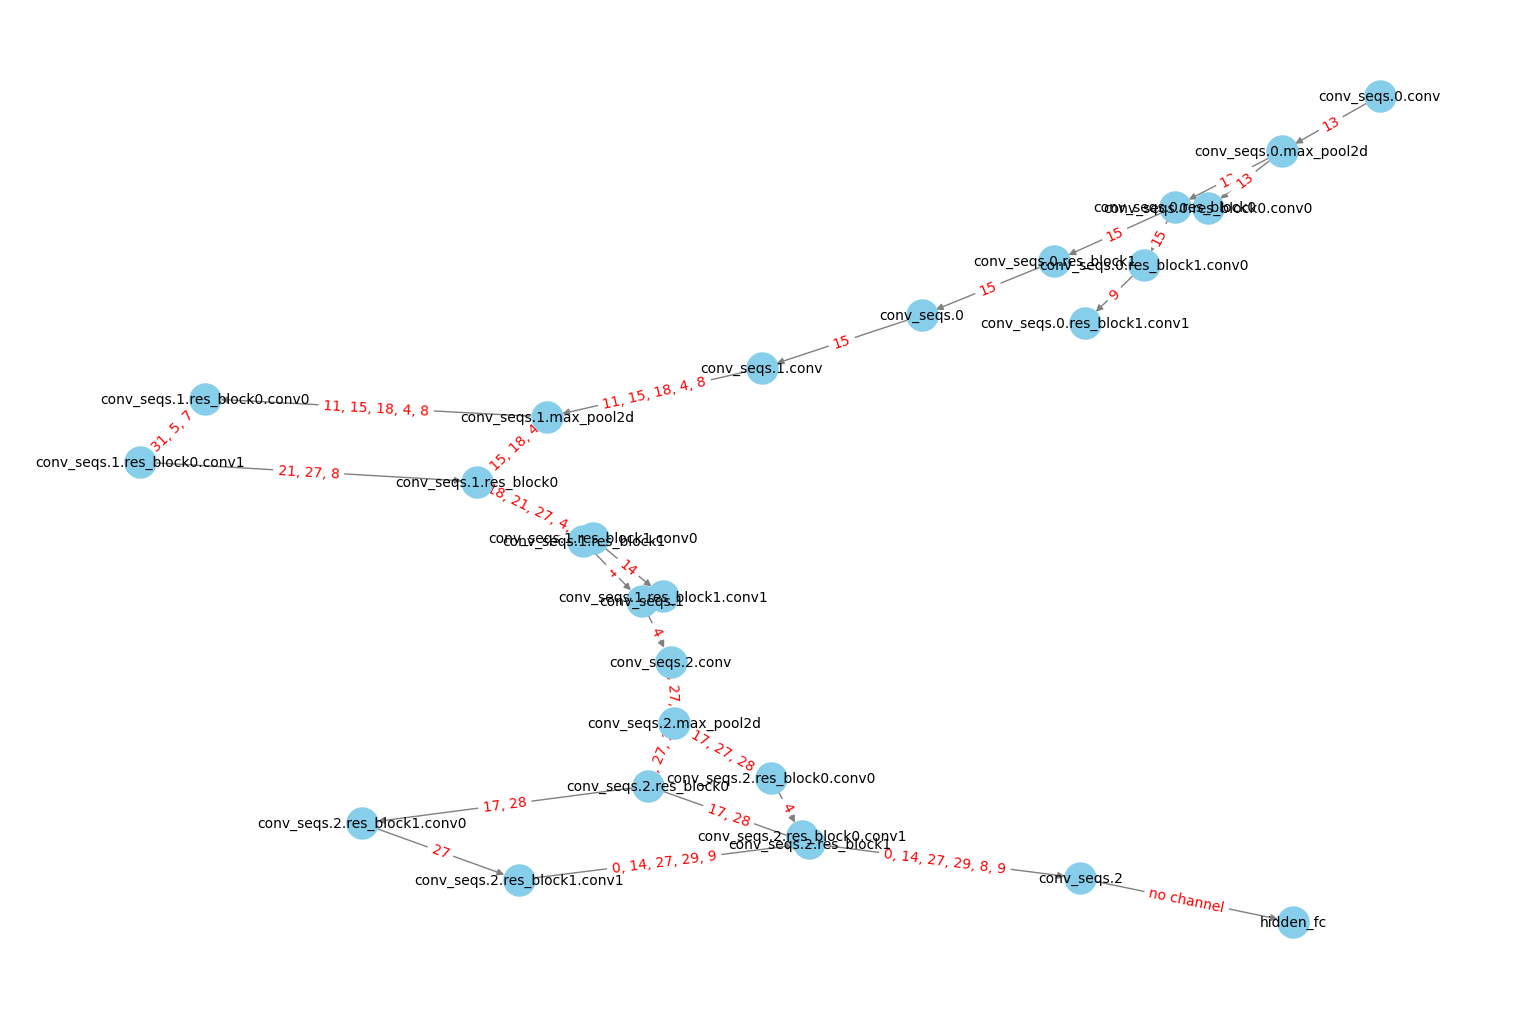

In [57]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy

def extract_channel_info(node_name):
    # Split the node name to extract the channel part if it exists
    parts = node_name.split('.')
    for part in parts:
        if "channel" in part:
            channel_number = part.replace('channel', '')  # Remove the 'channel' text to get just the number
            base_name = node_name.replace('.' + part, '')  # Remove the channel part from the base name
            return base_name, channel_number
    return node_name, None  # Return the original name if no channel info is present

def build_networkx_graph(graph):
    nx_graph = nx.DiGraph()
    
    # Temporary dictionary to hold aggregated edge data
    aggregated_edges = {}
    
    # Iterate over all nodes and their children to aggregate edge data
    for node_name, node in graph.nodes.items():
        base_node_name, node_channel = extract_channel_info(node_name)
        for child in node.children:
            base_child_name, child_channel = extract_channel_info(child.name)
            edge_key = (base_node_name, base_child_name)
            channel_pair = f"{node_channel}" if child_channel else "no channel"
            if edge_key not in aggregated_edges:
                aggregated_edges[edge_key] = {channel_pair}
            else:
                # Initialize with the current channel information
                aggregated_edges[edge_key].add(channel_pair)
    
    # Add aggregated edges to the NetworkX graph
    for (src, dst), channels in aggregated_edges.items():
        channel_info = ', '.join(sorted(channels))  # Combine all channels into a single string, sorted for consistency
        nx_graph.add_edge(src, dst, label=channel_info)

    return nx_graph

from networkx.drawing.nx_agraph import graphviz_layout
nx_graph = build_networkx_graph(experiment.graph)


# Compute the layout
pos = nx.kamada_kawai_layout(nx_graph)

# Manually scale the positions
for key, value in pos.items():
    pos[key] = [2 * x for x in value]  # Increase the multiplier to spread nodes further

plt.figure(figsize=(15, 10))
nx.draw(nx_graph, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=10, edge_color='gray')
# Get edge labels from the graph
edge_labels = nx.get_edge_attributes(nx_graph, 'label')

# Draw edge labels
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_color='red')
plt.show()
